In [1]:
import tensorsketch as ts
import tqdm
import numpy as np
from Bio import SeqIO
import glob
import matplotlib.pyplot as plt

In [20]:
kmer_size = 8               #@param {type:"slider",min:1,max:32,step:1}
tuple_size = 3              #@param {type:"slider",min:1,max:10,step:1}
sketch_dim = 10             #@param {type:"slider",min:10,max:300,step:10}
run_cuda_models = False     #@param {type:"boolean"}
alphabet_size = 4
seq_len = 5000000

window = 100000
stride = 20000
normalize = True
sample = ord('m')


common = dict(A=alphabet_size,D=sketch_dim)
tss = ts.TSS(t=tuple_size, S=stride, W=window, **common)

tsm = ts.TSM(t=tuple_size, S=stride, W=window, normalize=normalize,sample=sample,**common)

In [13]:

# Map from sequence characters to internal integer representation.
_char_map: dict[str, int] = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
_char_comp: dict[str, str] = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}

def reverse_complement(s) -> np.ndarray:
    char_list = np.full(len(s), -1, dtype=np.int8)
    for i in range(len(s)):
        char_list[i] = _char_map[_char_comp[s[-i-1]]]
    return char_list

# Given the char_map above, returns an array of length 256 mapping bytes to
# internal integers. -1 signals unknown bytes.
def seq2array(s) -> np.ndarray:
    char_list = np.full(len(s), -1, dtype=np.int8)
    for i,k in enumerate(s):
        char_list[i] = _char_map[k]
    return char_list

data = "/Users/amirjoudaki/Downloads/S_Baltica_new"
files = glob.glob(data + '/*')
print(files)

all_seqs = []
for file in files:
    records = SeqIO.to_dict(SeqIO.parse(file, "fasta"))
    for name,record in records.items():
        seq = dict(file = file, id=record.id, name=record.name, description=record.description)
        seq['seq'] = record.seq
        seq['array'] = seq2array(record.seq)
        seq['rarray'] = seq2array(record.seq)
        all_seqs.append(seq)

all_seqs

['/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS223.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS675.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS117.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS195.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS185.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS625.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_BA175.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS155.new.new.all.fna']


[{'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS223.new.new.all.fna',
  'id': 'CP001252.1',
  'name': 'CP001252.1',
  'description': 'CP001252.1 Shewanella baltica OS223 chromosome, complete genome 0',
  'seq': Seq('TTTTTTAAGGATAGCGATCCTTGAGATCTCGCTATAGAATACACCTCTTTTTTG...GCG'),
  'array': array([3, 3, 3, ..., 2, 1, 2], dtype=int8),
  'rarray': array([3, 3, 3, ..., 2, 1, 2], dtype=int8)},
 {'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS675.new.new.all.fna',
  'id': 'CP002383.1',
  'name': 'CP002383.1',
  'description': 'CP002383.1 Shewanella baltica OS678, complete genome 0',
  'seq': Seq('TTTAAGGATAGCGATCCTTGAGATCTCGCTATAGAATACACCTCTTTTTTGATG...TAA'),
  'array': array([3, 3, 3, ..., 3, 0, 0], dtype=int8),
  'rarray': array([3, 3, 3, ..., 3, 0, 0], dtype=int8)},
 {'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS117.new.new.all.fna',
  'id': 'C_017579.1',
  'name': 'C_017579.1',
  'description': 'C_017579.1 Shewanella baltica OS117, co

In [21]:
%%time
for seq in tqdm.tqdm(all_seqs,total=len(all_seqs)):
    # seq['sketch'] = dict(name='tss',
    #                      array=tss.sketch(seq['array'],flatten=False),
    #                      rarray=tss.sketch(seq['rarray'],flatten=False))
    sketch, inds = tsm.sketch(seq['array'])
    rsketch, rinds = tsm.sketch(seq['rarray'])
    seq['sketch'] = dict(name='tsm',
                         array=sketch,
                         inds=inds,
                         rarray=rsketch,
                         rinds=rinds)

100%|██████████| 8/8 [01:06<00:00,  8.30s/it]


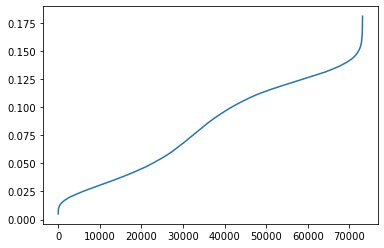

In [22]:
import edlib
import pandas as pd
s1, s2 = 0, 2
sk1, sk2 = all_seqs[s1]['sketch']['array'], all_seqs[s2]['sketch']['array']
dists = []
for i in range(sk1.shape[0]):
    for j in range(sk2.shape[0]):
        d = np.linalg.norm(sk1[i,:]-sk2[j,:])
        dists.append((i,j,d))
dists = np.array(dists)
idx = np.argsort(dists[:,2])
dists = dists[idx,:]
plt.plot(dists[:,2])

/var/folders/f_/k4t2qy550m59jflz950fy7z40000gn/T/ipykernel_41156/1669408119.py:13: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(prod) / np.pi


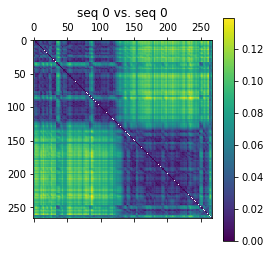

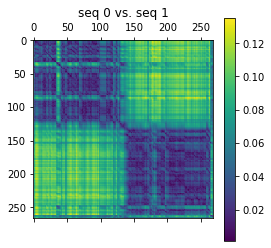

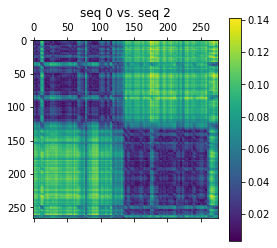

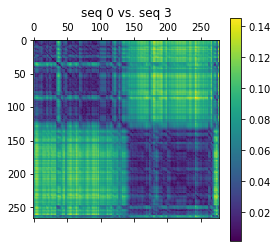

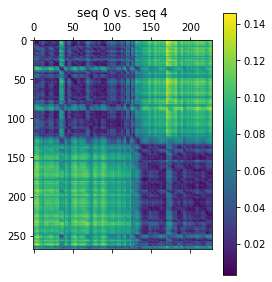

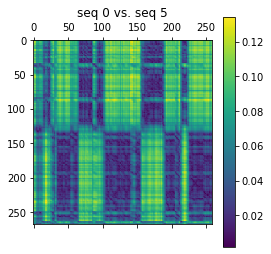

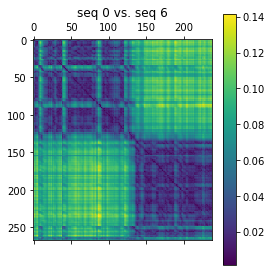

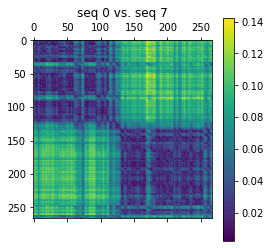

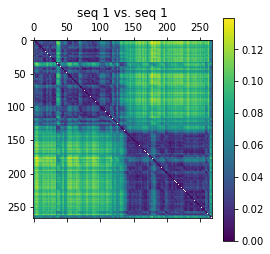

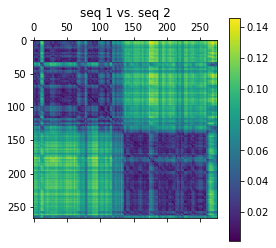

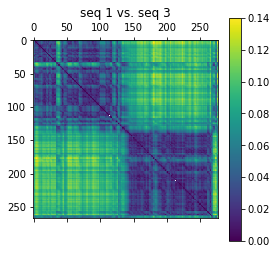

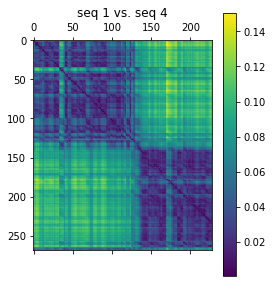

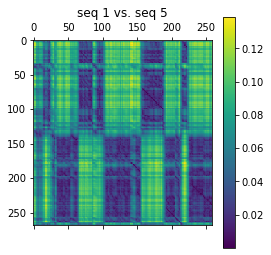

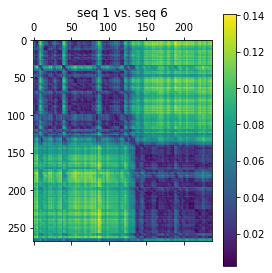

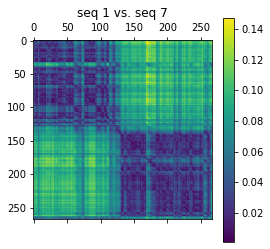

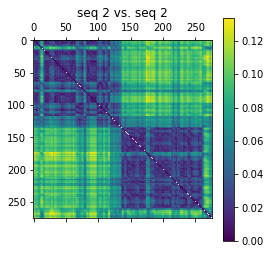

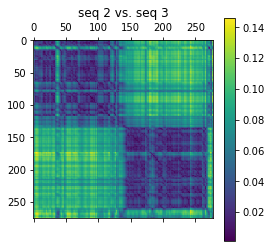

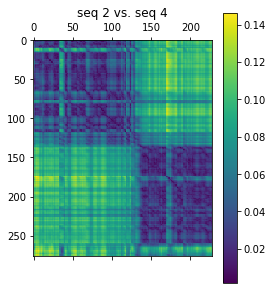

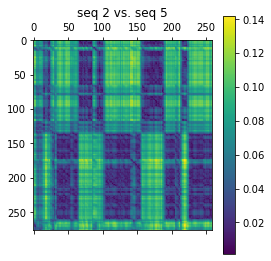

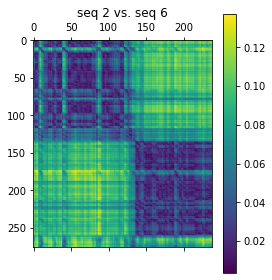

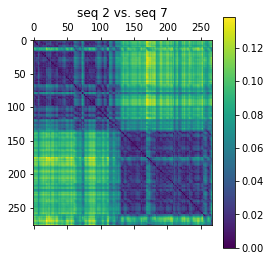

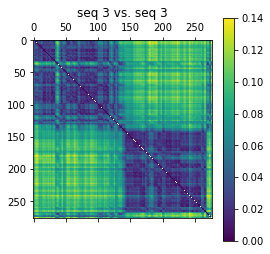

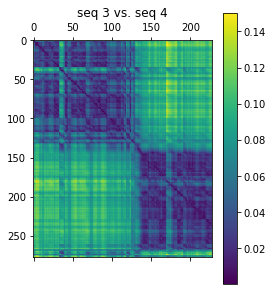

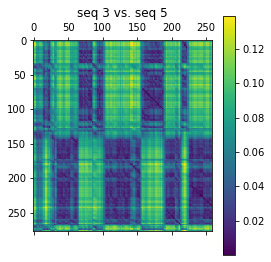

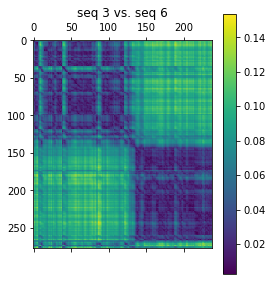

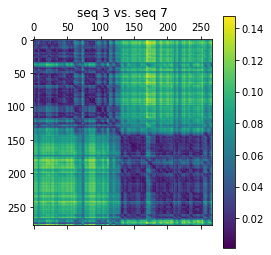

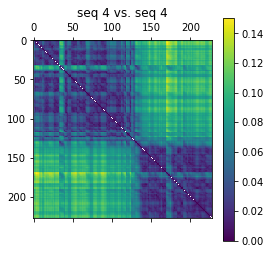

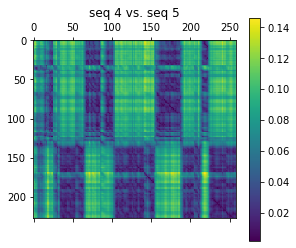

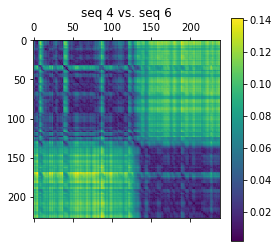

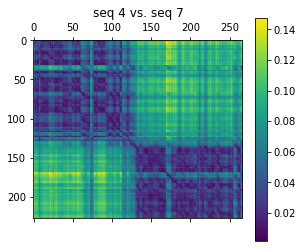

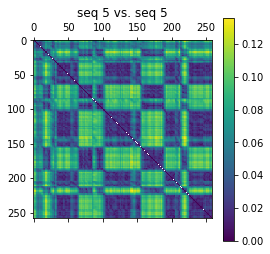

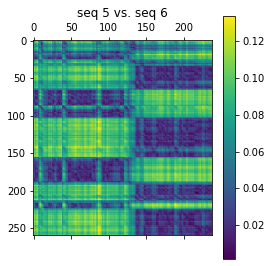

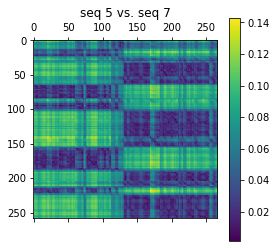

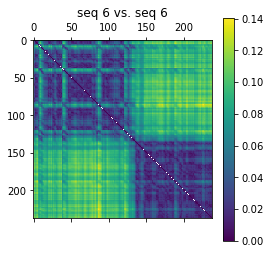

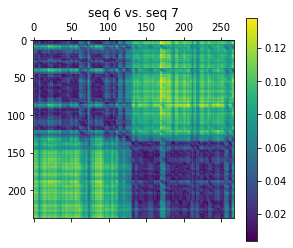

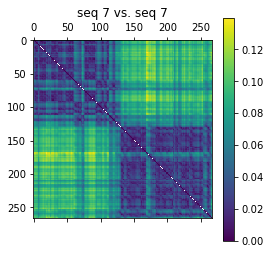

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt

N = len(all_seqs)

for i in range(N):
    for j in range(i,N):
        sk1 = all_seqs[i]['sketch']['array']
        sk2 = all_seqs[j]['sketch']['array']
        sk1 = sk1.transpose() / np.sqrt(np.sum(sk1**2,axis=1))
        sk2 = sk2.transpose() / np.sqrt(np.sum(sk2**2,axis=1))
        prod = np.matmul(sk1.transpose(),sk2)
        angle = np.arccos(prod) / np.pi

        plt.matshow(angle)
        plt.colorbar()
        plt.title(f'seq {i} vs. seq {j}')
        plt.show()

(array([109.,   0.,   0.,   0.,   0.,  61.,   0.,   0.,  21.,   6.]),
 array([0.00000000e+00, 2.58095683e-09, 5.16191366e-09, 7.74287048e-09,
        1.03238273e-08, 1.29047841e-08, 1.54857410e-08, 1.80666978e-08,
        2.06476546e-08, 2.32286115e-08, 2.58095683e-08]),
 <BarContainer object of 10 artists>)

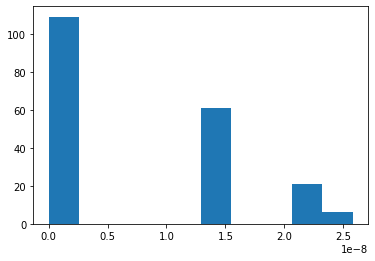

In [78]:
plt.hist(np.diag(angle))

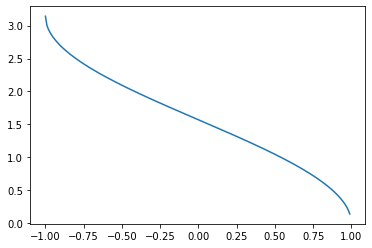

In [86]:
x = np.arange(-1,1,.01)
plt.plot(x,np.arccos(x))

3.141592653589793